# 机器学习期末大作业
- 姓名：黄逸轩 程佳诺
- 学号：2012067 2012628
- 专业：计算机科学与技术

### 实验要求
题目：基于VAE的手写数字生成

实验条件：MNIST手写数字数据集：http://yann.lecun.com/exdb/mnist/ 也可以通过 sklearn，pytorch 和 tensorflow 内置的函数直接下载。该数据集由60000个样本的训练集和10000个样本的测试集组成（生成模型中不需要测试集），规模较大，硬件条件有限的同学可以进行下采样(例如选取6000个样本)后进行建模和训练。

实验要求：
1. 基本要求：利用 pytorch (推荐) 或 tensorflow 等神经网络框架编程实现一个变分自编码器 (Variational Auto Encoder, VAE)；分别采用交叉熵损失 (Cross Entropy Loss) 和L2损失 (MSE Loss) 构建损失函数生成新的手写数字,分析结果并展示生成的手写数字；
2. 中级要求：实现VAE的变分推断(最好是手写推导)，描述VAE的由来以及优缺点；
3. 提高要求：实现任意形式的对VAE进行改进或创新，例如：和其他网络结合或对比（图卷积神经网络(GCN)，生成对抗网络(GAN)，Diffusion Model等）；实现VAE的变种（β-VAE，β-TCVAE等）；修改数据集（例如加噪点，加mask等）以发掘VAE更多的功能；对可视化方法进行创新（例如输出隐变量）……

**截止日期：初步定于2023年1月7日**
- 以.ipynb形式的文件提交，输出运行结果，并确保自己的代码能够正确运行；
- 可以1-3人为一小组的形式进行提交，提交的文件中需要写明每个小组成员的贡献；
- 发送到邮箱：2120220594@mail.nankai.edu.cn；

### 小组成员贡献：
2012067黄逸轩：基本要求、中级要求、报告框架搭建

2012628程佳诺：提高要求、报告汇总修改

### 目录结构：
ipynb文件正常运行后，目录结构应如下：

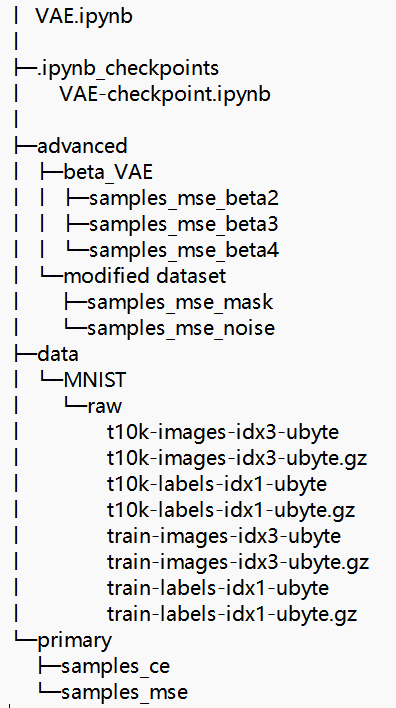

其中，data文件夹中为pytorch下载的数据集，primary文件夹为基本要求部分生成结果，包含交叉熵损失结果samples_ce文件夹和MSE损失结果samples_mse；advanced文件夹为提高要求部分生成结果，包括beta_VAE实现结果beta_VAE文件夹，下含samples_mse_data2/3/4文件夹，表示以mse构造损失函数超参数beta取值为2/3/4时的运行结果；修改数据集实现结果modified dataset文件夹，下含samples_mse_noise表示以mse构造损失函数处理方法为加噪点的运行结果与samples_mse_mask表示以mse构造损失函数处理方法为加mask的运行结果。每一个最内层文件夹中包含15个reconst和15个sampled图片，为解码结果。

一份成功的输出结果：

sampled.png：

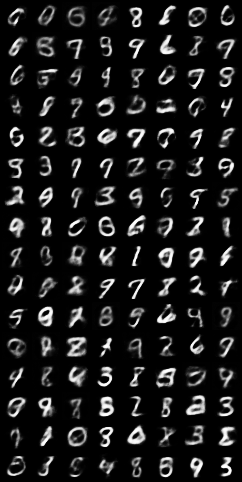

reconst.png:

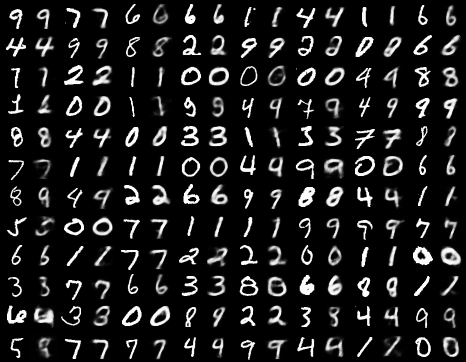

## 基本要求
本小组选择使用pytorch框架来辅助实现VAE模型

### 导入需要的包

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

### 配置CPU或者GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 创建目录保存生成的图片

In [3]:
sample_dir_ce = 'primary/samples_ce'
sample_dir_mse = 'primary/samples_mse'
if not os.path.exists(sample_dir_ce):
    os.makedirs(sample_dir_ce)
if not os.path.exists(sample_dir_mse):
    os.makedirs(sample_dir_mse)

### 超参数设置

In [4]:
image_size = 784   #图片大小
h_dim = 400
z_dim = 20
num_epochs = 15   #15个循环
batch_size = 128   #一批的数量
learning_rate = 1e-3   #学习率

 ### 获取数据集

In [5]:
dataset = torchvision.datasets.MNIST(root='./data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



### 数据加载
按照batch_size大小加载，并随机打乱

In [6]:
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

### VAE模型类的定义

In [7]:
# VAE模型
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
 
    # 编码，学习高斯分布均值与方差
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
 
    # 将高斯分布均值与方差参数重表示，生成隐变量z  若x~N(mu, var*var)分布,则(x-mu)/var=z~N(0, 1)分布
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std
 
    # 解码隐变量z
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
 
    # 计算重构值和隐变量z的分布参数
    def forward(self, x):
        mu, log_var = self.encode(x)  # 从原始样本x中学习隐变量z的分布，即学习服从高斯分布均值与方差
        z = self.reparameterize(mu, log_var)  # 将高斯分布均值与方差参数重表示，生成隐变量z
        x_reconst = self.decode(z)  # 解码隐变量z，生成重构x’
        return x_reconst, mu, log_var  # 返回重构值和隐变量的分布参数

### 构造VAE实例对象

In [8]:
model = VAE().to(device)
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=400, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=784, bias=True)
)


### 选择优化器，并传入VAE模型参数和学习率

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 开始训练

#### 采用交叉熵损失

In [10]:
# 开始训练一共15个循环
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # 前向传播
        x = x.to(device).view(-1,image_size)  # 将batch_size*1*28*28 ---->batch_size*image_size  其中，image_size=1*28*28=784
        x_reconst, mu, log_var = model(x)  # 将batch_size*748的x输入模型进行前向传播计算,重构值和服从高斯分布的隐变量z的分布参数（均值和方差）
 
        # 计算重构损失和KL散度
        # 重构损失
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        # KL散度
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
 
        # 反向传播与优化
        # 计算误差(重构误差和KL散度值)
        loss = reconst_loss + kl_div
        # 清空上一步的残余更新参数值
        optimizer.zero_grad()
        # 误差反向传播, 计算参数更新值
        loss.backward()
        # 将参数更新值施加到VAE model的parameters上
        optimizer.step()
        # 每迭代一定步骤，打印结果值
        if (i + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss(ce): {:.4f}, KL Div: {:.4f}, Total Loss: {:.4f}"
                  .format(epoch + 1, num_epochs, i + 1, len(data_loader), reconst_loss.item(), kl_div.item(),loss.item()))
 
    with torch.no_grad():
        # 保存采样值
        # 生成随机数 z
        z = torch.randn(batch_size, z_dim).to(device)  # z的大小为batch_size * z_dim = 128*20
        # 对随机数 z 进行解码decode输出
        out = model.decode(z).view(-1, 1, 28, 28)
        # 保存结果值
        save_image(out, os.path.join(sample_dir_ce, 'sampled-{}.png'.format(epoch + 1)))
 
        # 保存重构值
        # 将batch_size*748的x输入模型进行前向传播计算，获取重构值out
        out, _, _ = model(x)
        # 将输入与输出拼接在一起输出保存  batch_size*1*28*（28+28）=batch_size*1*28*56
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir_ce, 'reconst-{}.png'.format(epoch + 1)))

F:\anaconda\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
F:\anaconda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/15], Step [50/469], Reconst Loss(ce): 25841.7500, KL Div: 871.4764, Total Loss: 26713.2266
Epoch[1/15], Step [100/469], Reconst Loss(ce): 22817.9414, KL Div: 1279.1807, Total Loss: 24097.1211
Epoch[1/15], Step [150/469], Reconst Loss(ce): 19654.7539, KL Div: 1881.8120, Total Loss: 21536.5664
Epoch[1/15], Step [200/469], Reconst Loss(ce): 17491.5469, KL Div: 1983.8588, Total Loss: 19475.4062
Epoch[1/15], Step [250/469], Reconst Loss(ce): 15699.1064, KL Div: 2130.8135, Total Loss: 17829.9199
Epoch[1/15], Step [300/469], Reconst Loss(ce): 15941.3203, KL Div: 2224.9939, Total Loss: 18166.3145
Epoch[1/15], Step [350/469], Reconst Loss(ce): 14809.4883, KL Div: 2367.1362, Total Loss: 17176.6250
Epoch[1/15], Step [400/469], Reconst Loss(ce): 15230.5918, KL Div: 2485.4124, Total Loss: 17716.0039
Epoch[1/15], Step [450/469], Reconst Loss(ce): 14278.8789, KL Div: 2614.6392, Total Loss: 16893.5176
Epoch[2/15], Step [50/469], Reconst Loss(ce): 13349.8496, KL Div: 2741.2227, Total Loss: 1609

#### 采用L2损失（MSE）

In [11]:
# 构造VAE实例对象
model = VAE().to(device)
 
# 选择优化器，并传入VAE模型参数和学习率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 开始训练一共15个循环
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # 前向传播
        x = x.to(device).view(-1,image_size)  # 将batch_size*1*28*28 ---->batch_size*image_size  其中，image_size=1*28*28=784
        x_reconst, mu, log_var = model(x)  # 将batch_size*748的x输入模型进行前向传播计算,重构值和服从高斯分布的隐变量z的分布参数（均值和方差）
 
        # 计算重构损失和KL散度
        # 重构损失
        reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
        # KL散度
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
 
        # 反向传播与优化
        # 计算误差(重构误差和KL散度值)
        loss = reconst_loss + kl_div
        # 清空上一步的残余更新参数值
        optimizer.zero_grad()
        # 误差反向传播, 计算参数更新值
        loss.backward()
        # 将参数更新值施加到VAE model的parameters上
        optimizer.step()
        # 每迭代一定步骤，打印结果值
        if (i + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss(mse): {:.4f}, KL Div: {:.4f}, Total Loss: {:.4f}"
                  .format(epoch + 1, num_epochs, i + 1, len(data_loader), reconst_loss.item(), kl_div.item(),loss.item()))
 
    with torch.no_grad():
        # 保存采样值
        # 生成随机数 z
        z = torch.randn(batch_size, z_dim).to(device)  # z的大小为batch_size * z_dim = 128*20
        # 对随机数 z 进行解码decode输出
        out = model.decode(z).view(-1, 1, 28, 28)
        # 保存结果值
        save_image(out, os.path.join(sample_dir_mse, 'sampled-{}.png'.format(epoch + 1)))
 
        # 保存重构值
        # 将batch_size*748的x输入模型进行前向传播计算，获取重构值out
        out, _, _ = model(x)
        # 将输入与输出拼接在一起输出保存  batch_size*1*28*（28+28）=batch_size*1*28*56
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir_mse, 'reconst-{}.png'.format(epoch + 1)))

Epoch[1/15], Step [50/469], Reconst Loss(mse): 6973.7300, KL Div: 154.3004, Total Loss: 7128.0303
Epoch[1/15], Step [100/469], Reconst Loss(mse): 6396.5352, KL Div: 361.9924, Total Loss: 6758.5273
Epoch[1/15], Step [150/469], Reconst Loss(mse): 5510.8750, KL Div: 610.3787, Total Loss: 6121.2539
Epoch[1/15], Step [200/469], Reconst Loss(mse): 4777.3623, KL Div: 791.0031, Total Loss: 5568.3652
Epoch[1/15], Step [250/469], Reconst Loss(mse): 4434.1787, KL Div: 932.3185, Total Loss: 5366.4971
Epoch[1/15], Step [300/469], Reconst Loss(mse): 4133.1909, KL Div: 1002.0323, Total Loss: 5135.2231
Epoch[1/15], Step [350/469], Reconst Loss(mse): 3866.7673, KL Div: 1082.1986, Total Loss: 4948.9658
Epoch[1/15], Step [400/469], Reconst Loss(mse): 3775.3081, KL Div: 1095.6543, Total Loss: 4870.9624
Epoch[1/15], Step [450/469], Reconst Loss(mse): 3451.5962, KL Div: 1175.2139, Total Loss: 4626.8101
Epoch[2/15], Step [50/469], Reconst Loss(mse): 3319.1658, KL Div: 1152.6489, Total Loss: 4471.8145
Epoch[2

## 中级要求

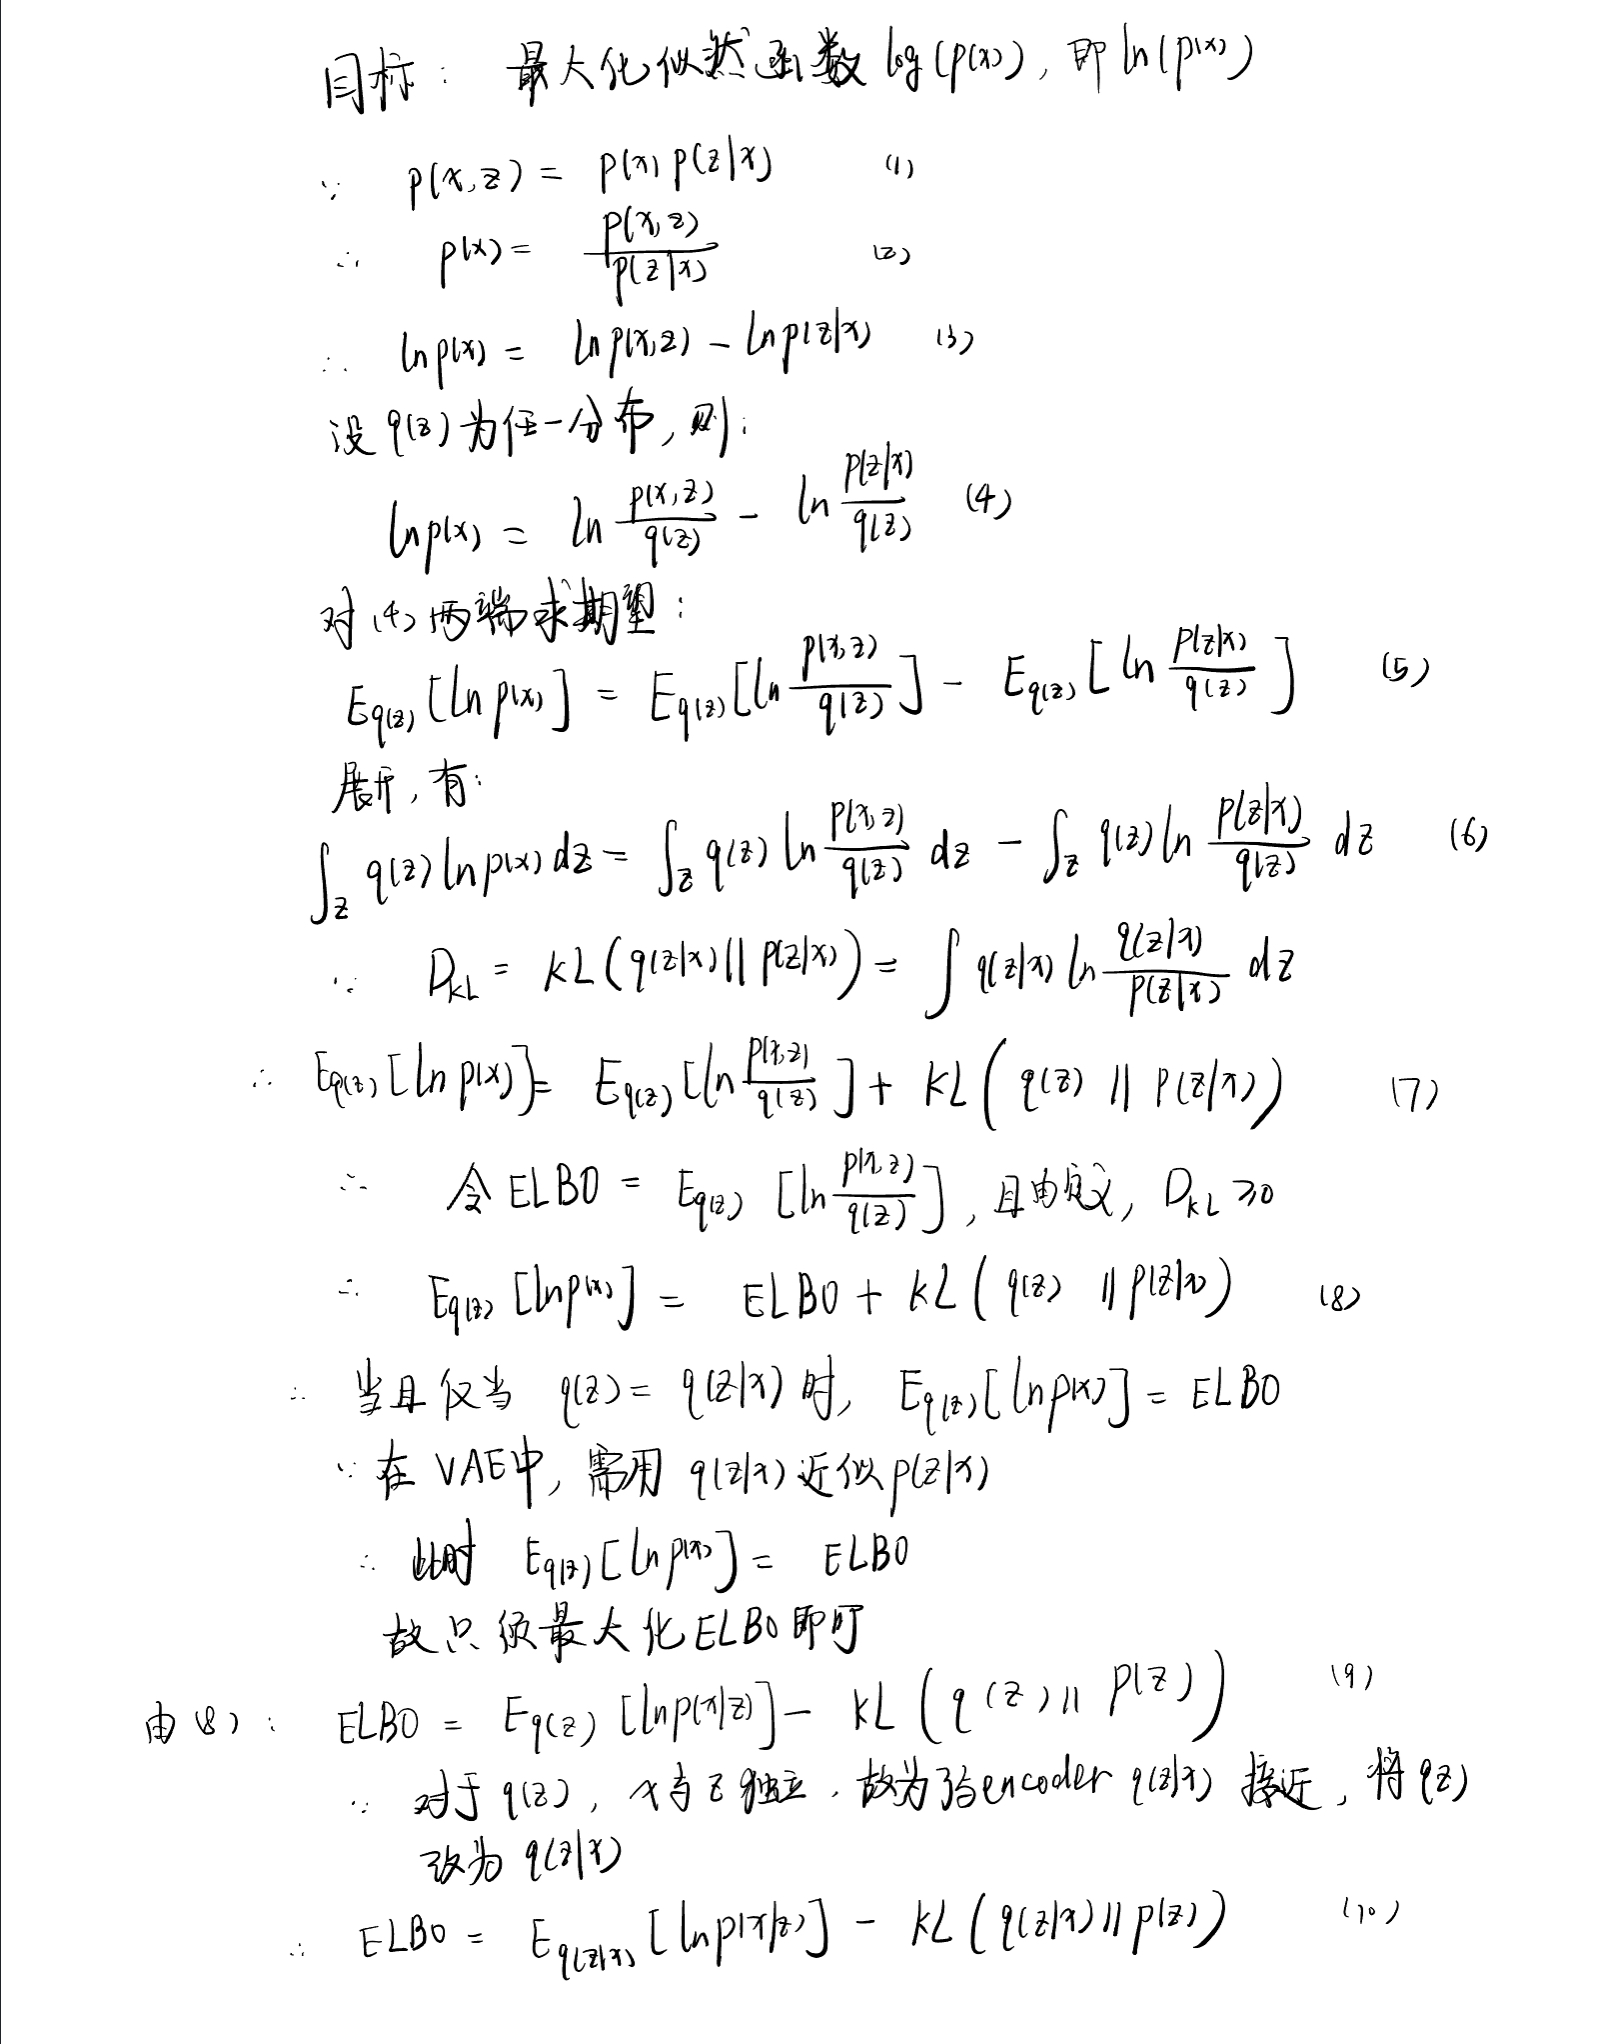

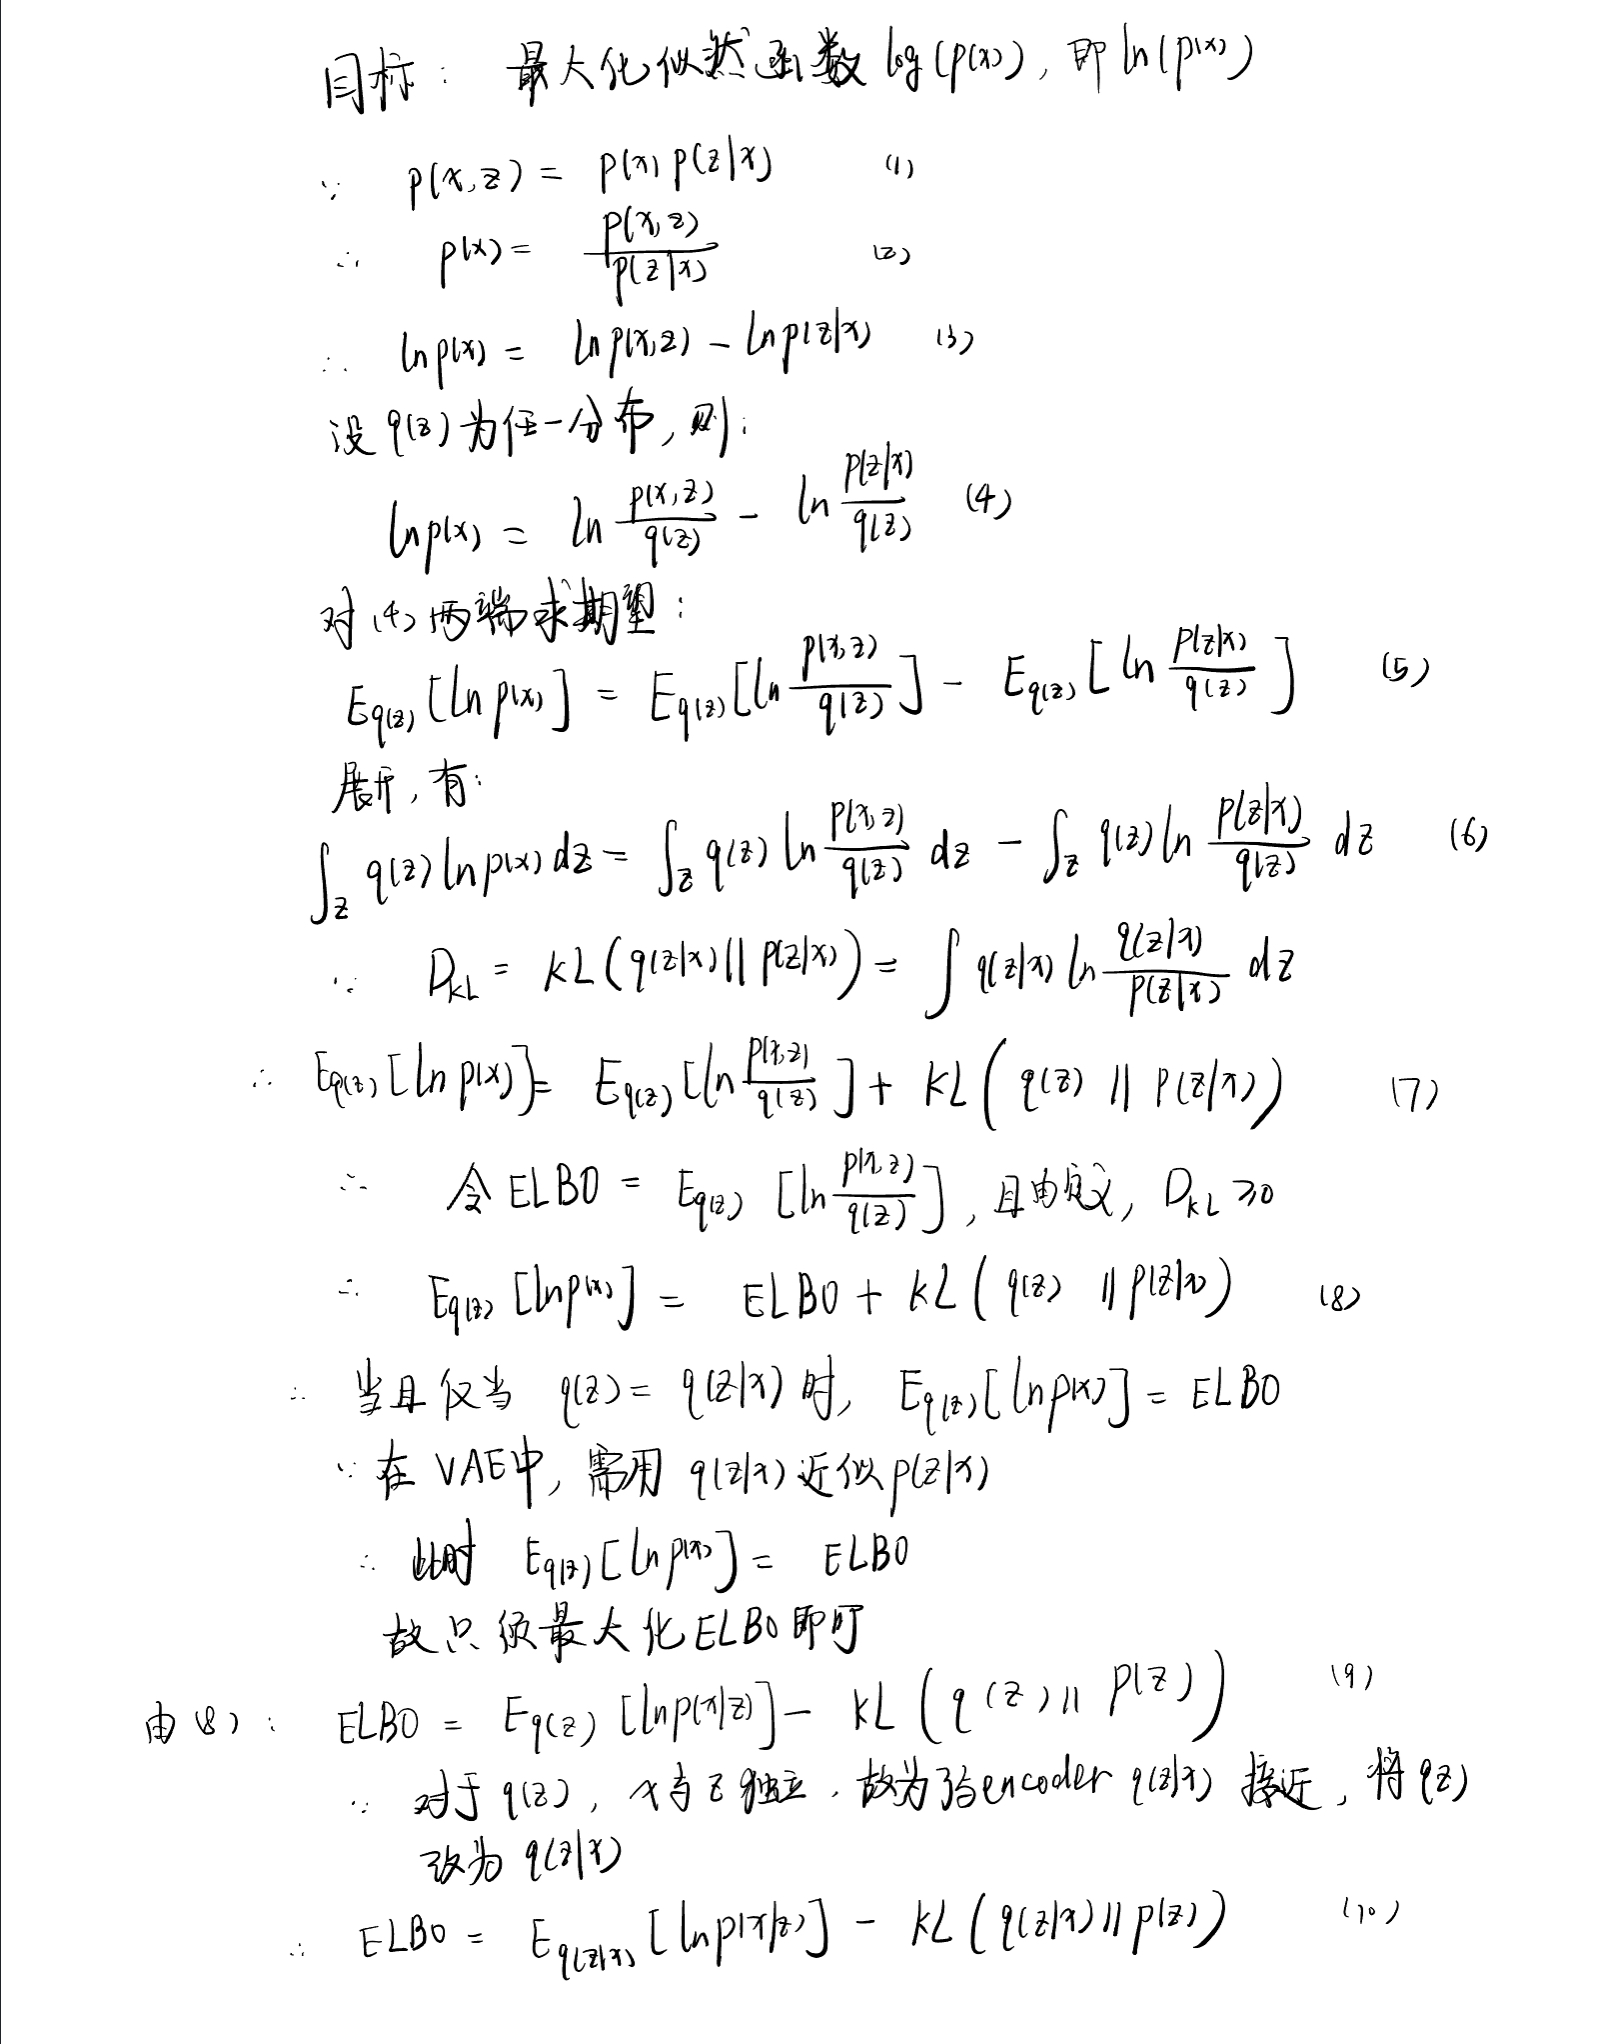

## 提高要求

为代码简洁与方便，提高要求部分仅使用mse构建损失函数。

### 提高要求1：实现VAE的变种
在这里选择实现beta-VAE。beta-VAE 是一种使用了自定义的 Kullback-Leibler divergence（KL 散度）来强化 VAE 的约束条件的模型。在 beta-VAE 中，自定义的 KL 散度表达式为：D_KL(q(z|x)||p(z)) = - beta * D_KL(q(z|x)||p(z)) + (1 - beta) * D_KL(p(z|x)||p(z))。其中，q(z|x) 表示 VAE 中的变分分布，p(z) 表示先验分布（例如标准正态分布），p(z|x) 表示 VAE 的重构分布，D_KL 表示KL 散度的计算公式，beta 是超参数。

在 beta-VAE 中，使用自定义的 KL 散度可以调节 VAE 的约束条件的强度。当 beta 值较小时，VAE 的约束条件较弱，解码的重构图像可能会更加复杂；当 beta 值较大时，VAE 的约束条件较强，解码的重构图像可能会更加简单。

具体到代码实现，只需加入超参数beta，在计算误差时将原来的loss = reconst_loss + kl_div公式变为loss = reconst_loss + beta * kl_div即可。

查阅资料可知，超参数beta取值一般为1.0-4.0。由于beta取值为1.0时即为VAE，从略，下面分别讨论beta取值为2.0、3.0和4.0时的三种情况。

为简洁美观，在本部分中未变动代码部分注释将被删去，只注释变动部分，方便查看。下同。

#### beta=2.0

In [12]:
#创建新目录保存结果
sample_dir_mse_beta2 = 'advanced/beta_VAE/samples_mse_beta2'
if not os.path.exists(sample_dir_mse_beta2):
    os.makedirs(sample_dir_mse_beta2)

model = VAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#超参数beta
beta = 2.0

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1,image_size)  
        x_reconst, mu, log_var = model(x)  
 
        reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
        # 自定义KL散度
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        kl_div = beta * kl_div
        
        loss = reconst_loss + kl_div
        
        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()

        if (i + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss(mse): {:.4f}, KL Div: {:.4f}, Total Loss: {:.4f}"
                  .format(epoch + 1, num_epochs, i + 1, len(data_loader), reconst_loss.item(), kl_div.item(),loss.item()))
 
    with torch.no_grad():
        # 改变保存路径
        z = torch.randn(batch_size, z_dim).to(device)  
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir_mse_beta2, 'sampled-{}.png'.format(epoch + 1)))
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir_mse_beta2, 'reconst-{}.png'.format(epoch + 1)))

Epoch[1/15], Step [50/469], Reconst Loss(mse): 6882.8687, KL Div: 83.9953, Total Loss: 6966.8638
Epoch[1/15], Step [100/469], Reconst Loss(mse): 6162.1074, KL Div: 303.2543, Total Loss: 6465.3618
Epoch[1/15], Step [150/469], Reconst Loss(mse): 5793.8018, KL Div: 516.1176, Total Loss: 6309.9194
Epoch[1/15], Step [200/469], Reconst Loss(mse): 5570.1294, KL Div: 708.6630, Total Loss: 6278.7925
Epoch[1/15], Step [250/469], Reconst Loss(mse): 5242.6924, KL Div: 781.3737, Total Loss: 6024.0659
Epoch[1/15], Step [300/469], Reconst Loss(mse): 5101.3135, KL Div: 957.2191, Total Loss: 6058.5327
Epoch[1/15], Step [350/469], Reconst Loss(mse): 4950.3765, KL Div: 989.1937, Total Loss: 5939.5703
Epoch[1/15], Step [400/469], Reconst Loss(mse): 4762.7905, KL Div: 1017.2475, Total Loss: 5780.0381
Epoch[1/15], Step [450/469], Reconst Loss(mse): 4564.7910, KL Div: 1103.0527, Total Loss: 5667.8438
Epoch[2/15], Step [50/469], Reconst Loss(mse): 4634.7363, KL Div: 1173.0780, Total Loss: 5807.8145
Epoch[2/15

### beta=3.0

In [13]:
#创建新目录保存结果
sample_dir_mse_beta3 = 'advanced/beta_VAE/samples_mse_beta3'
if not os.path.exists(sample_dir_mse_beta3):
    os.makedirs(sample_dir_mse_beta3)

model = VAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#超参数beta
beta = 3.0

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1,image_size)  
        x_reconst, mu, log_var = model(x)  
 
        reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
        # 自定义KL散度
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        kl_div = beta * kl_div
        
        loss = reconst_loss + kl_div
        
        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()

        if (i + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss(mse): {:.4f}, KL Div: {:.4f}, Total Loss: {:.4f}"
                  .format(epoch + 1, num_epochs, i + 1, len(data_loader), reconst_loss.item(), kl_div.item(),loss.item()))
 
    with torch.no_grad():
        # 改变保存路径
        z = torch.randn(batch_size, z_dim).to(device)  
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir_mse_beta3, 'sampled-{}.png'.format(epoch + 1)))
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir_mse_beta3, 'reconst-{}.png'.format(epoch + 1)))

Epoch[1/15], Step [50/469], Reconst Loss(mse): 6949.1338, KL Div: 51.3836, Total Loss: 7000.5176
Epoch[1/15], Step [100/469], Reconst Loss(mse): 6746.3647, KL Div: 92.0626, Total Loss: 6838.4272
Epoch[1/15], Step [150/469], Reconst Loss(mse): 6391.7490, KL Div: 289.6360, Total Loss: 6681.3848
Epoch[1/15], Step [200/469], Reconst Loss(mse): 6149.4678, KL Div: 419.2592, Total Loss: 6568.7271
Epoch[1/15], Step [250/469], Reconst Loss(mse): 5888.3672, KL Div: 543.5140, Total Loss: 6431.8813
Epoch[1/15], Step [300/469], Reconst Loss(mse): 5473.0894, KL Div: 650.7188, Total Loss: 6123.8081
Epoch[1/15], Step [350/469], Reconst Loss(mse): 5502.8989, KL Div: 728.5730, Total Loss: 6231.4717
Epoch[1/15], Step [400/469], Reconst Loss(mse): 5963.5820, KL Div: 766.3141, Total Loss: 6729.8960
Epoch[1/15], Step [450/469], Reconst Loss(mse): 5229.5342, KL Div: 858.2072, Total Loss: 6087.7412
Epoch[2/15], Step [50/469], Reconst Loss(mse): 5334.2959, KL Div: 970.3969, Total Loss: 6304.6929
Epoch[2/15], S

#### beta=4.0

In [14]:
#创建新目录保存结果
sample_dir_mse_beta4 = 'advanced/beta_VAE/samples_mse_beta4'
if not os.path.exists(sample_dir_mse_beta4):
    os.makedirs(sample_dir_mse_beta4)

model = VAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#超参数beta
beta = 4.0

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1,image_size)  
        x_reconst, mu, log_var = model(x)  
 
        reconst_loss = F.mse_loss(x_reconst, x, size_average=False)
        # 自定义KL散度
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        kl_div = beta * kl_div
        
        loss = reconst_loss + kl_div
        
        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()

        if (i + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss(mse): {:.4f}, KL Div: {:.4f}, Total Loss: {:.4f}"
                  .format(epoch + 1, num_epochs, i + 1, len(data_loader), reconst_loss.item(), kl_div.item(),loss.item()))
 
    with torch.no_grad():
        # 改变保存路径
        z = torch.randn(batch_size, z_dim).to(device)  
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir_mse_beta4, 'sampled-{}.png'.format(epoch + 1)))
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir_mse_beta4, 'reconst-{}.png'.format(epoch + 1)))

Epoch[1/15], Step [50/469], Reconst Loss(mse): 6727.6816, KL Div: 43.6697, Total Loss: 6771.3516
Epoch[1/15], Step [100/469], Reconst Loss(mse): 6632.5908, KL Div: 102.6924, Total Loss: 6735.2832
Epoch[1/15], Step [150/469], Reconst Loss(mse): 6717.6885, KL Div: 185.1254, Total Loss: 6902.8140
Epoch[1/15], Step [200/469], Reconst Loss(mse): 6151.7539, KL Div: 336.1330, Total Loss: 6487.8867
Epoch[1/15], Step [250/469], Reconst Loss(mse): 6440.7261, KL Div: 329.4766, Total Loss: 6770.2026
Epoch[1/15], Step [300/469], Reconst Loss(mse): 6153.4189, KL Div: 390.7791, Total Loss: 6544.1982
Epoch[1/15], Step [350/469], Reconst Loss(mse): 5967.6929, KL Div: 442.2342, Total Loss: 6409.9272
Epoch[1/15], Step [400/469], Reconst Loss(mse): 5985.0469, KL Div: 561.6875, Total Loss: 6546.7344
Epoch[1/15], Step [450/469], Reconst Loss(mse): 5768.0679, KL Div: 703.1777, Total Loss: 6471.2456
Epoch[2/15], Step [50/469], Reconst Loss(mse): 5837.5669, KL Div: 611.3806, Total Loss: 6448.9473
Epoch[2/15], 

### 提高要求2：修改数据集以发掘VAE更多的功能

#### 添加噪点

由于VAE模型使用pytorch库构建，而pytorch并没有直接在数据集中添加噪点的库函数。因此，在这里选择使用随机仿射变换函数实现添加噪点。

随机仿射变换是一种常见的图像变换方法，可以在保持图像内容不变的前提下，随机调整图像的尺度、旋转角度、平移位置等参数。

通常，随机仿射变换可以用来扩充训练数据集，增强模型的泛化能力。

但是，当随机仿射变换的参数设置得较大时，可能会产生噪点的效果。

具体来说，在使用 torchvision.transforms.RandomAffine 函数时，我们使用 translate 参数来设置平移的范围，当 translate 参数设置为较大的值时，图像会被平移较大的距离，导致图像中出现较多的噪点。

In [15]:
#创建新目录保存结果
sample_dir_mse_noise = 'advanced/modified dataset/samples_mse_noise'
if not os.path.exists(sample_dir_mse_noise):
    os.makedirs(sample_dir_mse_noise)

#定义随机变换
transform_noise = transforms.Compose([
    transforms.ToTensor(),  # 将 PIL 图像转换为张量
    transforms.Normalize((0.5,), (0.5,)),  # 归一化
    transforms.RandomAffine(degrees=0,translate=(0.005, 0.005)),  # 随机仿射变换
])

#对数据集进行添加噪点
dataset_noise = torchvision.datasets.MNIST(root='./data',
                                     train=True,
                                     transform=transform_noise,
                                     download=True)

data_loader_noise = torch.utils.data.DataLoader(dataset=dataset_noise,
                                              batch_size=batch_size,
                                              shuffle=True)

model = VAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

beta = 1.0

for epoch in range(num_epochs):
    #使用添加噪点的数据集
    for i, (x, _) in enumerate(data_loader_noise):
        x = x.to(device).view(-1,image_size)  
        x_reconst, mu, log_var = model(x)  
 
        reconst_loss = F.mse_loss(x_reconst, x, size_average=False)

        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        kl_div = beta * kl_div
        
        loss = reconst_loss + kl_div
        
        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()

        if (i + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss(mse): {:.4f}, KL Div: {:.4f}, Total Loss: {:.4f}"
                  .format(epoch + 1, num_epochs, i + 1, len(data_loader_noise), reconst_loss.item(), kl_div.item(),loss.item()))
 
    with torch.no_grad():
        # 改变保存路径
        z = torch.randn(batch_size, z_dim).to(device)  
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir_mse_noise, 'sampled-{}.png'.format(epoch + 1)))
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir_mse_noise, 'reconst-{}.png'.format(epoch + 1)))

Epoch[1/15], Step [50/469], Reconst Loss(mse): 93391.5781, KL Div: 1362.7610, Total Loss: 94754.3359
Epoch[1/15], Step [100/469], Reconst Loss(mse): 93249.2891, KL Div: 927.4186, Total Loss: 94176.7109
Epoch[1/15], Step [150/469], Reconst Loss(mse): 93102.4375, KL Div: 798.4313, Total Loss: 93900.8672
Epoch[1/15], Step [200/469], Reconst Loss(mse): 92827.4375, KL Div: 542.5956, Total Loss: 93370.0312
Epoch[1/15], Step [250/469], Reconst Loss(mse): 93213.7891, KL Div: 431.1582, Total Loss: 93644.9453
Epoch[1/15], Step [300/469], Reconst Loss(mse): 92891.9766, KL Div: 408.7987, Total Loss: 93300.7734
Epoch[1/15], Step [350/469], Reconst Loss(mse): 93079.7188, KL Div: 528.0323, Total Loss: 93607.7500
Epoch[1/15], Step [400/469], Reconst Loss(mse): 92705.6953, KL Div: 317.5992, Total Loss: 93023.2969
Epoch[1/15], Step [450/469], Reconst Loss(mse): 92617.3594, KL Div: 262.1071, Total Loss: 92879.4688
Epoch[2/15], Step [50/469], Reconst Loss(mse): 92652.6406, KL Div: 361.3977, Total Loss: 93

#### 添加mask
为了添加mask，我们在输入图像的中央区域创建一个掩码，并使用该掩码将图像的中心区域替换为全零张量。然后，我们将这个掩码与输入图像进行按位或运算，从而得到一个新的输入图像。

具体到代码实现，我们需要重写VAE类，在VAE的init函数中定义mask，以便实例化时一起初始化。

在VAE类的forward函数中使用mask进行运算。在解码隐变量z之前，使用mask与隐变量z进行按位或运算，从而创建新的隐变量z'。接下来，使用z'替换z，并使用z'解码为重构值x'。最后，使用x'计算 VAE 的损失函数。

In [16]:
class VAE_mask(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE_mask, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
        #定义掩码
        self.mask = torch.zeros(1, z_dim, dtype=torch.float)
        self.mask[:, :10] = 1.0  
 
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
 
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std
 
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
 
    def forward(self, x):
        mu, log_var = self.encode(x)  
        z = self.reparameterize(mu, log_var)  
        #使用mask得到新的隐变量z'
        z = z * self.mask * 100
        x_reconst = self.decode(z)  
        return x_reconst, mu, log_var  

#创建新目录保存结果
sample_dir_mse_mask = 'advanced/modified dataset/samples_mse_mask'
if not os.path.exists(sample_dir_mse_mask):
    os.makedirs(sample_dir_mse_mask)

#使用带有mask的VAE类
model_mask = VAE_mask().to(device)

optimizer = torch.optim.Adam(model_mask.parameters(), lr=learning_rate)

beta = 1.0

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1,image_size)  
        #使用带有mask的model
        x_reconst, mu, log_var = model_mask(x)  
 
        reconst_loss = F.mse_loss(x_reconst, x, size_average=False)

        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        kl_div = beta * kl_div
        
        loss = reconst_loss + kl_div
        
        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()

        if (i + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss(mse): {:.4f}, KL Div: {:.4f}, Total Loss: {:.4f}"
                  .format(epoch + 1, num_epochs, i + 1, len(data_loader), reconst_loss.item(), kl_div.item(),loss.item()))
 
    with torch.no_grad():
        # 改变保存路径
        z = torch.randn(batch_size, z_dim).to(device)  
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir_mse_mask, 'sampled-{}.png'.format(epoch + 1)))
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir_mse_mask, 'reconst-{}.png'.format(epoch + 1)))

Epoch[1/15], Step [50/469], Reconst Loss(mse): 10493.5264, KL Div: 178.6552, Total Loss: 10672.1816
Epoch[1/15], Step [100/469], Reconst Loss(mse): 9772.5898, KL Div: 415.7194, Total Loss: 10188.3096
Epoch[1/15], Step [150/469], Reconst Loss(mse): 9779.2715, KL Div: 457.2917, Total Loss: 10236.5635
Epoch[1/15], Step [200/469], Reconst Loss(mse): 9312.2783, KL Div: 537.2988, Total Loss: 9849.5771
Epoch[1/15], Step [250/469], Reconst Loss(mse): 9348.5742, KL Div: 643.9611, Total Loss: 9992.5352
Epoch[1/15], Step [300/469], Reconst Loss(mse): 9596.4463, KL Div: 682.2031, Total Loss: 10278.6494
Epoch[1/15], Step [350/469], Reconst Loss(mse): 8738.9092, KL Div: 649.4675, Total Loss: 9388.3770
Epoch[1/15], Step [400/469], Reconst Loss(mse): 8543.0957, KL Div: 736.7505, Total Loss: 9279.8457
Epoch[1/15], Step [450/469], Reconst Loss(mse): 9172.5273, KL Div: 770.6074, Total Loss: 9943.1348
Epoch[2/15], Step [50/469], Reconst Loss(mse): 8370.0693, KL Div: 780.9128, Total Loss: 9150.9824
Epoch[2

### 提高要求3：对可视化方法进行创新
对隐变量z进行输出。使用t-SNE算法将z降维到二维，然后使用散点图可视化z。
为了可视化输出z，我们需要重写VAE类，返回隐变量z。

Epoch[1/15], Step [50/469], Reconst Loss(ce): 6871.3501, KL Div: 163.4820, Total Loss: 7034.8320
Epoch[1/15], Step [100/469], Reconst Loss(ce): 6022.7070, KL Div: 323.4783, Total Loss: 6346.1855
Epoch[1/15], Step [150/469], Reconst Loss(ce): 5133.9048, KL Div: 610.7886, Total Loss: 5744.6934
Epoch[1/15], Step [200/469], Reconst Loss(ce): 4841.2222, KL Div: 742.7969, Total Loss: 5584.0190
Epoch[1/15], Step [250/469], Reconst Loss(ce): 4525.0947, KL Div: 864.1104, Total Loss: 5389.2051
Epoch[1/15], Step [300/469], Reconst Loss(ce): 4404.1494, KL Div: 973.2102, Total Loss: 5377.3594
Epoch[1/15], Step [350/469], Reconst Loss(ce): 4088.4209, KL Div: 958.9673, Total Loss: 5047.3882
Epoch[1/15], Step [400/469], Reconst Loss(ce): 3949.4797, KL Div: 1073.9836, Total Loss: 5023.4634
Epoch[1/15], Step [450/469], Reconst Loss(ce): 3637.5469, KL Div: 1128.6135, Total Loss: 4766.1602
Epoch[2/15], Step [50/469], Reconst Loss(ce): 3427.3787, KL Div: 1173.3159, Total Loss: 4600.6943
Epoch[2/15], Step [

F:\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
F:\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


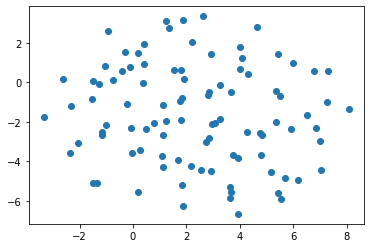

In [17]:
class VAE_returnz(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE_returnz, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
 
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
 
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std
 
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
 
    def forward(self, x):
        mu, log_var = self.encode(x)  
        z = self.reparameterize(mu, log_var)  
        x_reconst = self.decode(z)  
        #返回z
        return x_reconst, mu, log_var, z


#使用返回z的VAE类
model_returnz = VAE_returnz().to(device)

optimizer = torch.optim.Adam(model_returnz.parameters(), lr=learning_rate)

beta = 1.0

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1,image_size)  
        #使用返回z的model
        x_reconst, mu, log_var, returnz = model_returnz(x)  
 
        reconst_loss = F.mse_loss(x_reconst, x, size_average=False)

        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        kl_div = beta * kl_div
        
        loss = reconst_loss + kl_div
        
        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()

        if (i + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss(ce): {:.4f}, KL Div: {:.4f}, Total Loss: {:.4f}"
                  .format(epoch + 1, num_epochs, i + 1, len(data_loader), reconst_loss.item(), kl_div.item(),loss.item()))
 
        if (epoch==num_epochs-1 and i==len(data_loader)-1):
            from sklearn.manifold import TSNE
            import matplotlib.pyplot as plt

            # 将隐变量 z 投射到二维平面
            z_embedded = TSNE(n_components=2).fit_transform(returnz.detach().numpy())
            
            # 可视化隐变量
            plt.scatter(z_embedded[:, 0], z_embedded[:, 1])
            plt.show()

### 提高要求4：和其他网络对比

VAE (Variational Autoencoder)，GCN (Graph Convolutional Network)，GAN (Generative Adversarial Network) 和 Diffusion Model 是四种不同的深度学习模型，用于不同的应用程序。

VAE 是一种生成模型，用于从观测数据中学习潜在分布，并使用这些学习的特征生成新的样本。它基于自动编码器架构，其中一个编码器将输入数据映射到一个潜在空间，然后一个解码器将其还原为原始数据。

GCN (Graph Convolutional Network) 是一种用于处理图数据的深度学习模型。它使用卷积运算来捕获图中节点和边之间的关系，并使用这些关系进行图分类或图分割。它可以用于许多应用程序，如社交网络分析、药物发现和蛋白质结构预测。

GAN (Generative Adversarial Network) 是一种生成模型，由两个对抗的网络组成：一个生成器和一个判别器。生成器生成新的样本，而判别器试图分辨出哪些样本是真实的，哪些是生成的。通过不断调整这两个网络，GAN 可以学习生成与观测数据相似的样本。

Diffusion Model 是一种用于处理图数据的模型，用于预测节点的属性。它基于信息在图上的扩散过程，通过将属性值在节点之间传播来预测未知的属性。